# European jobs for Data Analyst entry level

**Purpose:** To visualize info on Data Analyst/BI Analyst entry level jobs in Europe <br>
**Data source:** сsv-file with offers parsed from LinkedIn for the period of a week (the date of parsing is 07-Sep-2022)

##Extracting features from html

According to our requirement description, we need
- job title
- city
- country
- job type (online, hybride, on-site)
- company name
- company size (number of employees)
- company field
- required hard skills
- offer date
- number of candidates for an offer


Let's import all the libraries we will need

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import seaborn as sns
from datetime import datetime
from datetime import timedelta

Let's read the csv-file. It is uploaded on Gooogle Docs and can be viewed publicly.

In [2]:

sheet_id = "1J1YaJspflrP-LV0MzJj1IXvTg0EHdVeqbxO5JRnip9c"
sheet_name = "masterskaya_yandex_2022_09_07"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

Then we can take a peek on the data:

In [3]:
df.sample()

,Unnamed: 0,html
521,521,"\n <div>\n <div class=""\n jobs-deta..."


We have html data in here. Let's take a look on the first element to see the structure and the tags we will need for further info extraction. To see the actual structure and visually locate the tags, we can use the exact LinkedIn link or insert the html-code into any code editor.

In [4]:
job = df['html'][0]
job

'\n  <div>\n    <div class="\n        jobs-details__main-content jobs-details__main-content--single-pane full-width\n        ">\n        \n<!---->\n      \n<!---->\n      <div>\n        <div class="jobs-unified-top-card t-14">\n  <div class="relative">\n\n    <div class="jobs-unified-top-card__content--two-pane">\n<!---->\n        <a href="/jobs/view/3258155313/?alternateChannel=search&amp;refId=xQWMq5sHxPa4BOVKDp0TKg%3D%3D&amp;trackingId=grGqx%2FHW0EZ%2BorBvEr%2Ft%2Bg%3D%3D&amp;trk=d_flagship3_search_srp_jobs" id="ember464" class="ember-view">\n          <h2 class="t-24 t-bold jobs-unified-top-card__job-title">Stage - Assistant Ingénieur Qualité - Beyrand (H/F)</h2>\n        </a>\n\n      <div class="jobs-unified-top-card__primary-description">\n          <span class="jobs-unified-top-card__subtitle-primary-grouping t-black">\n            <span class="jobs-unified-top-card__company-name">\n                  <a href="/company/hermes-group/life/" id="ember465" class="ember-view t-black 

We are going to use Beautiful Soup library to find all the job titles. They are hidden under h2 tags.

In [5]:
df['title'] = df['html'].apply(lambda x:  BeautifulSoup(x).find('h2').text.strip())

In [6]:
df.sample()

,Unnamed: 0,html,title
297,297,"\n <div>\n <div class=""\n jobs-deta...",Data Analytics Analyst


Next thing we can find is location. For each job we will find a corresponding tag and put it into a try-except cycle.

In [7]:
def get_geo(cell):
    try:
        return BeautifulSoup(cell).find('span', class_ = 'jobs-unified-top-card__bullet').text.strip()
    except:
        return np.nan

In [8]:
df['geo'] = df['html'].apply(get_geo)

In [9]:
df.sample()

,Unnamed: 0,html,title,geo
213,213,"\n <div>\n <div class=""\n jobs-deta...",Machine Learning Engineer,"Paris, Île-de-France, France"


We can extract the exact city and remove all the excessive info from the geo column

In [10]:
def get_city(cell):
    if len(cell.split(',')) > 1:
        return cell.split(',')[0].strip()
    elif "Metropolitan" in cell or "Greater" in cell:
        return cell.replace('Greater', '').replace('Metropolitan', '').replace('Area', '').replace('Region','').strip()
    else:
        return np.nan

In [11]:
df['city'] = df['geo'].apply(get_city)

In [12]:
df.sample()

,Unnamed: 0,html,title,geo,city
723,723,"\n <div>\n <div class=""\n jobs-deta...",Backend Engineer - Personalization,Sweden,NaN


Same thing, we can extract the exact country. 

In [13]:
def get_country(cell):
    if len(cell.split(',')) > 1:
        return cell.split(',')[-1].strip()
    elif "Metropolitan" in cell or "Greater" in cell or "Region" in cell:
        return np.nan
    else:
        return cell

In [14]:
df['country'] = df['geo'].apply(get_country)

In [15]:
df.sample()

,Unnamed: 0,html,title,geo,city,country
614,614,"\n <div>\n <div class=""\n jobs-deta...",Ing. Elettronico/Data Analyst,"Rome, Latium, Italy",Rome,Italy


Similarly, we can find job types.

In [16]:
def get_job_type(cell):
    try:
        return BeautifulSoup(cell).find('span', class_ = 'jobs-unified-top-card__workplace-type').text.strip()
    except:
        return np.nan 

In [17]:
df['job_type'] = df['html'].apply(get_job_type)

In [18]:
df.sample()

,Unnamed: 0,html,title,geo,city,country,job_type
487,487,"\n <div>\n <div class=""\n jobs-deta...",Software Engineer - Application Frameworks and...,"Dublin, County Dublin, Ireland",Dublin,Ireland,Hybrid


...and company names

In [19]:
def get_company_name(cell):
    try:
        return BeautifulSoup(cell).find('span', class_ = 'jobs-unified-top-card__company-name').text.strip()
    except:
        return np.nan  

In [20]:
df['company_name'] = df['html'].apply(get_company_name)

In [21]:
df.sample()

,Unnamed: 0,html,title,geo,city,country,job_type,company_name
284,284,"\n <div>\n <div class=""\n jobs-deta...",Data Internet Analyst,Kortrijk Metropolitan Area,Kortrijk,NaN,Remote,Appen


...and number of employees working for these companies.

In [22]:
def get_employee_number(cell):
    try:
        return BeautifulSoup(cell).find('div', class_= 'mt5 mb2').find_all('li')[1].text.strip().split(' · ')[0].strip().split(' ')[0].strip()
    except:
        return np.nan  

In [23]:
df['employee_number'] = df['html'].apply(get_employee_number)

In [24]:
df.sample()

,Unnamed: 0,html,title,geo,city,country,job_type,company_name,employee_number
133,133,"\n <div>\n <div class=""\n jobs-deta...",Graduate Developer (J12998),"Albufeira, Faro, Portugal",Albufeira,Portugal,Remote,Pareto,201-500


...and number of candidates for the job.

In [25]:
def get_candidates(cell):
    try:
        return BeautifulSoup(cell).find('span', class_ = 'jobs-unified-top-card__applicant-count').text.strip().split(' ')[0].strip()
    except:
        return np.nan

In [26]:
df['candidates'] = df['html'].apply(get_candidates)

In [27]:
df.sample()

,Unnamed: 0,html,title,geo,city,country,job_type,company_name,employee_number,candidates
227,227,"\n <div>\n <div class=""\n jobs-deta...","Data Analyst with Spanish (shifts), Corporate ...","Gdynia, Pomorskie, Poland",Gdynia,Poland,Hybrid,LSEG (London Stock Exchange Group),"10,001+",3


...and a company's field.

In [28]:
def get_company_field(cell):
    try:
        return BeautifulSoup(cell).find('div', class_= 'mt5 mb2').find_all('li')[1].text.strip().split(' · ')[1].strip()
    except:
        return np.nan  

In [29]:
df['company_field'] = df['html'].apply(get_company_field)

In [30]:
df.sample()

,Unnamed: 0,html,title,geo,city,country,job_type,company_name,employee_number,candidates,company_field
185,185,"\n <div>\n <div class=""\n jobs-deta...",Data Development Analyst,"Madrid, Community of Madrid, Spain",Madrid,Spain,On-site,"Solera, Inc.","5,001-10,000",7,IT Services and IT Consulting


To retrieve sets of skills we can use a ready-made list of Data Anlysts' skills.

In [31]:
skills = (['datahub', 'api', 'github', 'google analytics', 'adobe analytics', 'ibm coremetrics', 'omniture'
            'gitlab', 'erwin', 'hadoop', 'spark', 'hive'
           'databricks', 'aws', 'gcp', 'azure','excel',
            'redshift', 'bigquery', 'snowflake',  'hana'
            'grafana', 'kantar', 'spss', 
           'asana', 'basecamp', 'jira', 'dbeaver','trello', 'miro', 'salesforce', 
           'rapidminer', 'thoughtspot',  'power point',  'docker', 'jenkins','integrate.io', 'talend', 'apache nifi','aws glue','pentaho','google data flow',
             'azure data factory','xplenty','skyvia','iri voracity','xtract.io','dataddo', 'ssis',
             'hevo data','informatica','oracle data integrator','k2view','cdata sync','querysurge', 
             'rivery', 'dbconvert', 'alooma', 'stitch', 'fivetran', 'matillion','streamsets','blendo',
             'iri voracity','logstash', 'etleap', 'singer', 'apache camel','actian', 'airflow', 'luidgi', 'datastage',
           'python', 'vba', 'scala', ' r ', 'java script', 'julia', 'sql', 'matlab', 'java', 'html', 'c++', 'sas',
           'data studio', 'tableau', 'looker', 'powerbi', 'cognos', 'microstrategy', 'spotfire',
             'sap business objects','microsoft sql server', 'oracle business intelligence', 'yellowfin',
             'webfocus','sas visual analytics', 'targit', 'izenda',  'sisense', 'statsbot', 'panorama', 'inetsoft',
             'birst', 'domo', 'metabase', 'redash', 'power bi', 'alteryx', 'dataiku', 'qlik sense', 'qlikview'
          ]) 

In [32]:
def get_skills(cell):
    list_skills = []
    for skill in skills:
        if skill in cell.lower().replace('powerbi', 'power bi'):
            list_skills.append(skill)
    return list_skills

In [33]:
df['skills'] = df['html'].apply(lambda x: BeautifulSoup(x).find('div', {'id':'job-details'}).text.strip()).apply(get_skills)

In [34]:
df.sample()

,Unnamed: 0,html,title,geo,city,country,job_type,company_name,employee_number,candidates,company_field,skills
644,644,"\n <div>\n <div class=""\n jobs-deta...",Data Engineer (m/f/d) - Pricing Intelligence,"Munich, Bavaria, Germany",Munich,Germany,NaN,Flix,"1,001-5,000",7,Travel Arrangements,"[aws, snowflake, docker, jenkins, airflow, pyt..."


We also can find the exact date for each job offer; we know that the date of parsing is 07-Sep-2022. LinkedIn gives you dates in "x minutes/hours/days ago" format, so we will get around this with timedelta.

In [35]:
def get_date(cell):
    try:
        return BeautifulSoup(cell).find('span', class_= 'jobs-unified-top-card__posted-date').text.strip()
    except:
        return np.nan

In [36]:
df['date'] = (df['html'].apply(get_date))

In [37]:
df.sample()

,Unnamed: 0,html,title,geo,city,country,job_type,company_name,employee_number,candidates,company_field,skills,date
288,288,"\n <div>\n <div class=""\n jobs-deta...",Online Data Analyst,"Split, Split-Dalmatia, Croatia",Split,Croatia,Remote,TELUS International,"10,001+",17,IT Services and IT Consulting,[],6 days ago


In [38]:
date_parsing_str = "2022-09-07"
date_parsing = datetime.strptime(date_parsing_str, "%Y-%m-%d")
def get_right_date(cell):
    if 'days' in cell or 'day' in cell:
        number_of_days = int(cell.split(' ')[0])
        cell = (date_parsing - timedelta(days=number_of_days)).strftime('%Y-%m-%d')
    else:
        cell = date_parsing.strftime('%Y-%m-%d')
    return cell 

In [39]:
df['date'] = df['date'].apply(get_right_date)

In [40]:
df.sample()

,Unnamed: 0,html,title,geo,city,country,job_type,company_name,employee_number,candidates,company_field,skills,date
451,451,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,United Kingdom,NaN,United Kingdom,Remote,Endeavor,"5,001-10,000",NaN,Entertainment Providers,"[aws, azure, excel, snowflake, python, r , sq...",2022-09-05


In [41]:
df.date.unique()

array(['2022-09-07', '2022-09-03', '2022-09-01', '2022-09-02',
       '2022-09-05', '2022-09-06', '2022-09-04'], dtype=object)

We will also need exact links for distinctions of offers for Tableau.

In [42]:
df['link'] = df['html'].apply(lambda x: "https://linkedin.com" + BeautifulSoup(x).find('a').get('href'))

We've got all we wanted. So now let's make our data pretty - let's filter relevant offers, get rid of duplicates and excessive columns.

##Data cleaning

First, we'll take a look at job titles. Do we have relevant offers?

In [43]:
df.title.unique()

array(['Stage - Assistant Ingénieur Qualité - Beyrand (H/F)',
       'développeur matlab/simulink, secteur automobile f/h',
       'Online Data Analyst', 'Online Data Analyst - Belgium',
       'Data Analyst', 'Alternant/ Alternante data analyst M/F',
       'Alternant(e) Data Scientist (H/F)',
       'ALTERNANCE- TOTALENERGIES RENEWABLES - Data Engineer (H/F)',
       'Data Engineer (with Python)', 'Junior Test Analyst',
       'Data Analyst H/F',
       'Data Scientist e-Commerce & Acquisition Monétique',
       'Ingénieur de recherche en traitement de données de mobilité H/F',
       'INGENIERO/A PRODUCTO Y CALIDAD AUTOMOCIÓN',
       'Data Scientist - Experience', 'Stage - Data Analyst (H/F)',
       'Data Analyst (F/H)', 'Data Analyst (Tableau)',
       '(Junior) Data Scientist (m/w/d)', 'Junior Data Scientist',
       'Data Scientist en stage H/F',
       'Software Development Engineer (Seville // Madrid) (Madrid or Seville)',
       'DATA SCIENTIST', 'Online Data Analyst | Frenc

Oops, here we have some irrelevant ones. We will get rid of them.

In [44]:
len(df)

772

In [45]:
pattern = 'Data Ana|BI Ana|Business Intelligence Ana'
mask = df['title'].str.contains(pattern, case=False)
len(df[mask])

266

Uh-oh, from 772 to 266. However, now our data is clean.

In [46]:
df = df[mask].reset_index()

Do we have any duplicates?

In [47]:
df.duplicated(subset=['html']).sum()

0

Do we have any NaNs?

In [48]:
df.isna().sum()

index               0
Unnamed: 0          0
html                0
title               0
geo                 0
city               18
country            13
job_type           51
company_name        0
employee_number     1
candidates         28
company_field      20
skills              0
date                0
link                0
dtype: int64

Yes, we do. We can manually insert the missing info to 'country'.

In [49]:
df[df['country'].isna()].sample()

,index,Unnamed: 0,html,title,geo,city,country,job_type,company_name,employee_number,candidates,company_field,skills,date,link
174,344,344,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Greater Zurich Area,Zurich,NaN,Remote,Appen,"501-1,000",23,IT Services and IT Consulting,[excel],2022-09-02,https://linkedin.com/jobs/view/3243899023/?alt...


In [50]:
df.at[5,'country']='Poland'
df.at[13,'country']='Poland'
df.at[16,'country']='Sweden'
df.at[17,'country']='Poland'
df.at[19,'country']='Poland'
df.at[20,'country']='Scotland'
df.at[41,'country']='Poland'
df.at[61,'country']='Poland'
df.at[100,'country']='Romania'
df.at[103,'country']='Italy'
df.at[174,'country']='Switzerland'
df.at[183,'country']='Spain'
df.at[192,'country']='Spain'


In [51]:
df.country.unique()

array(['Sweden', 'Belgium', 'Germany', 'France', 'Poland', 'Gibraltar',
       'Scotland', 'United Kingdom', 'Finland', 'Switzerland',
       'Netherlands', 'Norway', 'Czechia', 'Bulgaria', 'Italy',
       'Portugal', 'Spain', 'Slovakia', 'Romania', 'Luxembourg',
       'Ireland', 'Croatia', 'Slovenia', 'Denmark', 'Greece', 'Hungary'],
      dtype=object)

We cannot do anything about the cities - the info is missing even in 'geo'.

In [52]:
df[df['city'].isna()].sample()

,index,Unnamed: 0,html,title,geo,city,country,job_type,company_name,employee_number,candidates,company_field,skills,date,link
39,70,70,"\n <div>\n <div class=""\n jobs-deta...",Data Analytics Engineer,Poland,NaN,Poland,Remote,EPAM Systems,"10,001+",24,IT Services and IT Consulting,[sql],2022-09-07,https://linkedin.com/jobs/view/3256715174/?alt...


Let's also fill our empty cells in for convenience

In [53]:
df[['city', 'employee_number', 'job_type', 'company_name', 'candidates', 'company_field']] = \
 df[['city', 'employee_number', 'job_type', 'company_name', 'candidates', 'company_field']].fillna('unknown')

In [54]:
df.isna().sum()

index              0
Unnamed: 0         0
html               0
title              0
geo                0
city               0
country            0
job_type           0
company_name       0
employee_number    0
candidates         0
company_field      0
skills             0
date               0
link               0
dtype: int64

In [55]:
df.columns

Index(['index', 'Unnamed: 0', 'html', 'title', 'geo', 'city', 'country',
       'job_type', 'company_name', 'employee_number', 'candidates',
       'company_field', 'skills', 'date', 'link'],
      dtype='object')

Let's delete unimportant columns

In [56]:
df = df.drop(['index', 'Unnamed: 0', 'html','geo'],axis=1)

In [57]:
df.sample()

,title,city,country,job_type,company_name,employee_number,candidates,company_field,skills,date,link
257,Scientific programmer and data analyst,Delft,Netherlands,On-site,Technische Universiteit Delft,"5,001-10,000",24,Research Services,"[python, matlab, c++]",2022-09-01,https://linkedin.com/jobs/view/3247572656/?alt...


Maybe it makes sense to make some categories for the "employee_number" column

In [58]:
df.employee_number.unique()

array(['10,001+', '201-500', '1,001-5,000', '51-200', '5,001-10,000',
       '501-1,000', '11-50', '1-10', 'Government', 'See', 'unknown', 'IT'],
      dtype=object)

We also have some artifacts in this column. Let's nullify them and create categories

In [59]:
df.loc[df["employee_number"] == "1-10", "employee_number"] = "small"
df.loc[df["employee_number"] == "11-50", "employee_number"] = "small"
df.loc[df["employee_number"] == "51-200", "employee_number"] = "small"
df.loc[df["employee_number"] == "201-500", "employee_number"] = "small"
df.loc[df["employee_number"] == "501-1,000", "employee_number"] = "small"

In [60]:

df.loc[df["employee_number"] == "Government", "employee_number"] = 'unknown'
df.loc[df["employee_number"] == "See", "employee_number"] = 'unknown'
df.loc[df["employee_number"] == "IT", "employee_number"] = 'unknown'

In [61]:
df.loc[df["employee_number"] == "1,001-5,000", "employee_number"] = "middle"
df.loc[df["employee_number"] == "5,001-10,000", "employee_number"] = "middle"

In [62]:
df.loc[df["employee_number"] == "10,001+", "employee_number"] = "big"

In [63]:
df.employee_number.unique()

array(['big', 'small', 'middle', 'unknown'], dtype=object)

For our further work in Tableu it's better to use the explode() function. 

In [64]:
df = df.explode('skills')

##Final file for Tableau

In [65]:
df.to_csv('linkedin_for_tableau.csv', index = False)

Final dashboard countained: 

1.   Amount of offers per sity of the map of Europe
2.   Top ten company fields
3.   Most popular hard skills 
4.   Amount of offers per country (%)
5.   Amount of offers per job type 
6.   Amount of offers per company size
7.   Top ten most popular hiring companies

Plus an indicator of the total amount of offers and two filters: by country and by job type.

Link to Tableau Public https://public.tableau.com/views/LinkedInDABIEntryLeveloffersfor01-07Sep2022/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

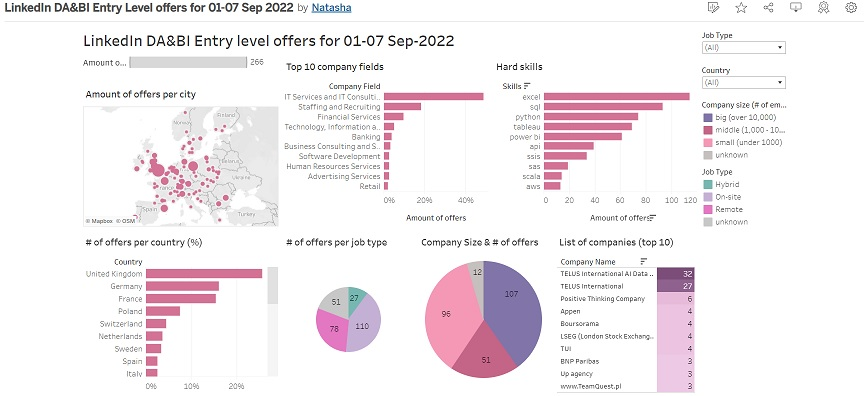

